In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# The Projects Goal: Understand and Simulate Perspective Projection with numpy and matplotlib

# NOTE: This project assumes a left-handed coordinate system, where the camera looks in positive z direction. Certain things need to be changed for a right-handed system.

In [3]:
# Define matrix operations for 3D transformations

def RodriguesRotation(axis, theta):
    """
    Returns the 4x4 rotation matrix in homogeneous coordinates associated with 
    counterclockwise rotation about the given axis by theta radians using Rodrigues' rotation formula.
    """
    # assert array
    axis = np.array(axis, dtype=np.float64)

    # assert float (theta in radians)
    theta = float(theta)

    # normalize the axis
    n = axis / np.linalg.norm(axis)

    # definition of the cross product operator of n
    n_x = np.array([[0, -n[2], n[1]],
                    [n[2], 0, -n[0]],
                    [-n[1], n[0], 0]])
    
    # squared cross product operator of n
    n_x2 = np.dot(n_x, n_x)

    # Rodrigues' rotation formula
    R = np.eye(3) + np.sin(theta) * n_x + (1 - np.cos(theta)) * n_x2

    # convert to 4x4 matrix or homogeneous coordinates
    R_homogeneous = np.eye(4)
    R_homogeneous[:3, :3] = R
    return R_homogeneous

def TranslationMatrix(translation):
    """
    Returns a 4x4 translation matrix in homogeneous coordinates for a given translation vector.
    """
    # assert array
    translation = np.array(translation, dtype=np.float64)

    T = np.eye(4)
    T[:3, 3] = translation
    return T

def ScaleMatrix(scale):
    """
    Returns a 4x4 scaling matrix in homogeneous coordinates for a given scale vector.
    """
    # number, make it a 3D scale vector
    if type(scale) in [int, float]:
        scale = (scale, scale, scale)

    # assert array
    scale = np.array(scale, dtype=np.float64)

    # scale
    S = np.eye(4)
    S[0, 0] = scale[0]
    S[1, 1] = scale[1]
    S[2, 2] = scale[2]
    return S

In [4]:
# build a cube class to generate a 3D cube defined by its edges and vertices, given a transformation matrix

class Cube3D:
    def __init__(self, matrix):
        # assume position centred at origin with side length 1

        # homogeneous coordinates
        self.vertices_model_space = np.array([
            [-0.5, -0.5, -0.5, 1.0],
            [ 0.5, -0.5, -0.5, 1.0],
            [ 0.5,  0.5, -0.5, 1.0],
            [-0.5,  0.5, -0.5, 1.0],
            [-0.5, -0.5,  0.5, 1.0],
            [ 0.5, -0.5,  0.5, 1.0],
            [ 0.5,  0.5,  0.5, 1.0],
            [-0.5,  0.5,  0.5, 1.0]])
        
        # connections between vertices to form edges
        self.edges = [(0,1), (1,2), (2,3), (3,0),
                      (4,5), (5,6), (6,7), (7,4),
                      (0,4), (1,5), (2,6), (3,7)]
        
        self._transform_to_world_space(matrix)
        
    def _transform_to_world_space(self, matrix):
        # apply a transformation matrix to the cube's vertices
        self.vertices_world_space = self.vertices_model_space @ matrix.T


In [5]:
# define a camera object via a transformation matrix, field of view, near and far planes
class Camera:
    def __init__(self,              
                 matrix: np.array = np.array([[1, 0, 0, 0],     # this matrix transformed the camera from its model space to world space
                                              [0, 1, 0, 0],     # similarly to the cube class.
                                              [0, 0, 1, 0],     # no entered transformation resorts to the identity matrix by default,
                                              [0, 0, 0, 1]]),   # that means position at origin, looking in positive z direction.
                 fov_h: float = 120,    # field of view horizontal in degrees
                 fov_v: float = 120,    # field of view vertical in degrees
                 near: float = 0.1,     # near clipping plane for normalized device coordinates (NDC)
                 far: float = 15,       # far clipping plane for normalized device coordinates (NDC)
                 ):
        # define camera extrinsics
        # define model properties
        self._model_properties()

        # transform to world space
        self._transform_to_world_space(matrix)

        # define camera intrinsics
        self.fov_h = fov_h
        self.fov_v = fov_v

        # define near and far planes
        self.near = near
        self.far = far

        # compute the individual matrices
        self._compute_view_matrix()
        self._compute_projection_matrix()

        # combine for the full view-projection matrix
        self._compute_view_projection_matrix()

    def _model_properties(self):
        # model coordinates and axis
        self.model_position = np.array([0, 0, 0, 1]) # origin
        
        # left handed coordinate system, camera looks in positive z direction
        self.model_forward = np.array([0, 0, 1, 0])
        self.model_up = np.array([0, 1, 0, 0])
        self.model_right = np.array([1, 0, 0, 0])

    def _transform_to_world_space(self, matrix):
        # transform the camera model to the world space using the provided matrix
        self.position = matrix @ self.model_position

        self.right = matrix @ self.model_right
        self.right = self.right / np.linalg.norm(self.right) # normalize

        self.up = matrix @ self.model_up
        self.up = self.up / np.linalg.norm(self.up) # normalize

        self.forward = matrix @ self.model_forward
        self.forward = self.forward / np.linalg.norm(self.forward) # normalize

        # assert the camera axes make sense
        #print(self.right[:3], self.up[:3], self.forward[:3])

    def _compute_view_matrix(self):
        # create the view matrix, which transforms world space into view space, where the camera is fixed at the origin and looks in positive z direction
        self.view_matrix = np.eye(4)
        self.view_matrix[0, :3] = self.right[:3]
        self.view_matrix[1, :3] = self.up[:3]
        self.view_matrix[2, :3] = self.forward[:3]

        # translation part
        translation = np.eye(4)
        translation[:3, 3] = -self.position[:3]

        # calculate the final view matrix, where first the world is translated, such that the camera is in the origin, then rotated such that the camera points at positive z
        self.view_matrix = self.view_matrix @ translation    
        
    def _compute_projection_matrix(self):
        # create the projection matrix based on the camera's field of view and near/far planes
        # f_h and f_v are the focal lengths in terms of pixels, assuming the image plane is 1 unit away from the camera
        f_h = 1 / np.tan(np.radians(self.fov_h) / 2)
        f_v = 1 / np.tan(np.radians(self.fov_v) / 2)

        # a and b define the transformation z' = a*z + b. As z' should be the depth in [0, 1], define (0 = a*near + b) and (1 = a*far + b)
        a = self.far/(self.far - self.near)
        b = -(self.far * self.near)/(self.far - self.near)

        # build the projection matrix
        self.projection_matrix = np.array([[f_h, 0,   0,  0],
                                           [0,   f_v, 0,  0],
                                           [0,   0,   a,  b],
                                           [0,   0,   1,  0]])
        
    def _compute_view_projection_matrix(self):
        # combine the view and projection matrices to get the model-view-projection matrix
        self.view_projection_matrix = self.projection_matrix @ self.view_matrix

    def project_vertices(self, vertices):
        # project 3D vertices into 2D using the view-projection matrix
        vertices_camera_space = (self.view_projection_matrix @ vertices.T).T

        # divide vertices_camera_space by their respective last component to get normalized device coordinates (NDC)
        vertices_ndc = vertices_camera_space / vertices_camera_space[:, 3][:, np.newaxis]

        # drop the last component to transform from homogeneous coordinates to 3D coordinates in NDC space
        vertices_ndc = vertices_ndc[:, :3]

        # clipping values outide the NDC cube 
        # vertices_ndc = vertices_ndc[(vertices_ndc[:,0] >= 0) & (vertices_ndc[:,0] <= 1) & (vertices_ndc[:,1] >= 0) & (vertices_ndc[:,1] <= 1)]

        return vertices_ndc


In [6]:
# object 1

# scale by 2
S = ScaleMatrix(2)

# translation by (0, 1, 3)
T = TranslationMatrix((0, 1, 3))

# first scale, then translate
model_matrix1 = T @ S

# create model with transformation matrix
C1 = Cube3D(model_matrix1)

In [7]:
# object 2

# rotation matrix around y axis by 30 degrees
R = RodriguesRotation(np.array([0,1,0]), np.radians(30))

# scale by 3
S = ScaleMatrix(3)

# translation by (2.5, 1.5, 5.5)
T = TranslationMatrix((2.5, 1.5, 5.5))

# first rotate, then scale, then translate
model_matrix2 = T @ S @ R

# create model with transformation matrix
C2 = Cube3D(model_matrix2)

In [8]:
# define the camera position and orientation via a transformation matrix
R1 = RodriguesRotation(np.array([0,1,0]), np.radians(-45))  # rotate around y axis by -45 degrees       --> "First, look 45° to the left"
R2 = RodriguesRotation(np.array([1,0,1]), np.radians(30))   # rotate around axis (1,0,1) by 30 degrees  --> "Then, look 30° down"
T = TranslationMatrix((3.5, 2.5, 0))                        # translate to (3.5, 2.5, 0)                --> "Then, move to (3.5, 2.5, 0)"

M = T @ R2 @ R1 # combined transformation matrix

In [15]:
Cam = Camera(matrix=M, fov_h=120, fov_v=120, near=0.1, far=15) # create the camera object

In [16]:
# project the two cube's vertices into 2D
proj_vertices1 = Cam.project_vertices(C1.vertices_world_space)
proj_vertices2 = Cam.project_vertices(C2.vertices_world_space)

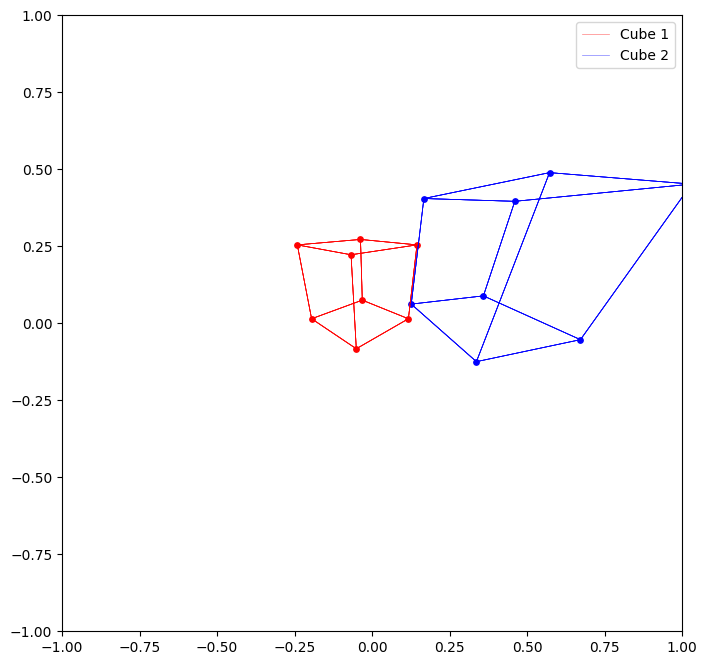

In [17]:
# plot the 2D projections of the two cubes

plt.figure(figsize=(8,8))

# cube 1 in red
for v in proj_vertices1:
    # plot vertices
    plt.scatter(v[0], v[1], s=15, c='r')

    # also draw the edges
    for edge in C1.edges:
        v1 = proj_vertices1[edge[0]]
        v2 = proj_vertices1[edge[1]]
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], c='r', lw=0.5, alpha=0.5)

# cube 2 in blue
for v in proj_vertices2:
    #plot vertices
    plt.scatter(v[0], v[1], s=15, c='b')

    # draw the edges
    for edge in C2.edges:
        v1 = proj_vertices2[edge[0]]
        v2 = proj_vertices2[edge[1]]
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], c='b', lw=0.5, alpha=0.5)


# manually add legend
plt.legend(handles=[
    plt.Line2D([0], [0], color='r', lw=0.5, alpha=0.5, label='Cube 1'),
    plt.Line2D([0], [0], color='b', lw=0.5, alpha=0.5, label='Cube 2')])
plt.xlim(-1, 1)
plt.ylim(-1, 1);